# Introduction

### Stated Objective(s) Here:
* Optimize gold production and eliminate unprofitable parameters within the mining process (i.e. extraction and purification level).

### Stated Goal(s) Here:
* Build a prototype model that will predict the amount of gold is recovered from gold ore.

### Initial Question(s): 
* Is there any minerals that goes beyond the standard process (i.e. needing several more pass-throughs to the purification process)?
* Does a shorter or lengther purification process harm or benefit an ore?

## Data Wrangling

### Libraries & Data

In [1]:
#Load Libraries Here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import RandomState
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

# from sklearn.model_selection import RandomizedSearchCV

In [2]:
#Load Data Here
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
full = pd.read_csv('/datasets/gold_recovery_full.csv')

#### Training Dataset

In [3]:
train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [5]:
train.duplicated().sum()

0

In [6]:
train.isna().sum().sum()

30320

This training set has a 86 columns, close to 17k entries per column, but has 30,320 missing observations in total.

#### Testing Dataset

In [7]:
test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [9]:
test.duplicated().sum()

0

In [10]:
test.isna().sum().sum()

2360

This testing dataset has 53 columns, two data types - with only one column being a object type - and close to 6k entries per column. Although have a little less than half of a column of missing observations for the entire set.

#### Full Dataset

In [11]:
full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [12]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [13]:
full.duplicated().sum()

0

In [14]:
full.isna().sum().sum()

36587

This full dataset has a 87 columns, close to 23k entries per column, but has 36,587 missing observations in total; similiar to the training set, the amount of missing observations is less than 3-4%. 

Right off the bat, I noticed if I were to drop any missing, null or NA values from the datasets, a relative small chunk of data would be missing in ratio to the total entries per dataset. So I will keep things as they are for now and will just consider filling in any empty observations for each dataset when I have to come a later decision for the ML model prototype. This is a given since most of the data is a continious value, so putting zeros or an atribtray number I don't think it would be that simple in this case.

### Recovery Calculation with MAE | Training Set's Features | Find the MAE between your calculations and the feature values.   Provide findings.

$$ 
Recovery = \frac{C \times (F - T)}{F \times (C - T)} \times 100\%
$$

* C = the amount of gold in the concentrate -- *post-flotation*
* F = the amount of gold in the feed  -- *before flotation*
* T = the amount of gold in the rougher tails -- *post flotation*

* Both Final & Rougher Concentrates Matter!

In [15]:
#the recovery function
def recovery(df, C, F, T):
    kickback = 100 * ((df[C] * (df[F] - df[T])) / (df[F] * (df[C] - df[T])))
    return kickback

In [16]:
calculated_values = recovery(train.dropna(subset=['rougher.output.recovery']), 'rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au')
actual_values = train['rougher.output.recovery'].dropna().to_list()

print(f"Mean Absolute Error: {mean_absolute_error(actual_values, calculated_values)}")

Mean Absolute Error: 9.303415616264301e-15


When exploring the training set's impression on the **rougher.output.recovery** feature through the recovery function and its MAE -- *9.30..1e-15* is quite a small value, yet seemingly a good thing to see. However, this can imply two things: 1st) that the result between the calculated and actual values there is hardly any difference and thus almost a perfect fit impression for our prototype or 2) we may need to test the datasets more in depth to see because on the surface level it may seem good but in reality there could be overfitting or a lack of data intergrity at play.

### Datasets' Features Analysis | Analyze the features not available in the test set. What are these parameters? What is their type?

After analyzing each dataframe, we can conclude that there are about 34 columns missing from the test dataframe compared to other (Full & Train) datasets. There are 2 data types for all dataframes: object & float64, and there are several thousands of missing value cells across all the datasets. I believe these parameters, that aren't available in the test dataframe, are outputs of the solutions & materials that are calculated much later and would've cause data leakage in our model if we didn't take notice of them now. So it would make sense why they aren't included in the test dataset.

In [17]:
train_col = train.columns
test_col = test.columns

differ_col = train_col.difference(test_col)
differ_col.value_counts().sum()

34

In [18]:
full[differ_col].isna().sum()

final.output.concentrate_ag                             89
final.output.concentrate_au                             86
final.output.concentrate_pb                             87
final.output.concentrate_sol                           385
final.output.recovery                                 1963
final.output.tail_ag                                    83
final.output.tail_au                                    81
final.output.tail_pb                                   200
final.output.tail_sol                                  271
primary_cleaner.output.concentrate_ag                   98
primary_cleaner.output.concentrate_au                   98
primary_cleaner.output.concentrate_pb                  448
primary_cleaner.output.concentrate_sol                 798
primary_cleaner.output.tail_ag                         102
primary_cleaner.output.tail_au                          99
primary_cleaner.output.tail_pb                         122
primary_cleaner.output.tail_sol                        3

In [19]:
full[differ_col].isna().sum().sum()

21559

### Data Preprocessing Performance

I listed the test's columns and then compared the columns to the train's columns and also assess their shapes.

In [20]:
#I identified the test's dataset's columns

test_col = test.columns.tolist()
test_col

['date',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air'

In [21]:
#then I filtered the training data features based on the test set

filtered_train = train[test_col]
filtered_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        16860 non-null  object 
 1   primary_cleaner.input.sulfate               15553 non-null  float64
 2   primary_cleaner.input.depressant            15598 non-null  float64
 3   primary_cleaner.input.feed_size             16860 non-null  float64
 4   primary_cleaner.input.xanthate              15875 non-null  float64
 5   primary_cleaner.state.floatbank8_a_air      16820 non-null  float64
 6   primary_cleaner.state.floatbank8_a_level    16827 non-null  float64
 7   primary_cleaner.state.floatbank8_b_air      16820 non-null  float64
 8   primary_cleaner.state.floatbank8_b_level    16833 non-null  float64
 9   primary_cleaner.state.floatbank8_c_air      16822 non-null  float64
 10  primary_cl

In [22]:
filtered_train.shape

(16860, 53)

In [23]:
test.shape

(5856, 53)

In [24]:
full['final.output.recovery'].isna().value_counts()

False    20753
True      1963
Name: final.output.recovery, dtype: int64

In [25]:
full['final.output.recovery'].describe()

count    20753.000000
mean        67.447488
std         11.616034
min          0.000000
25%         63.282393
50%         68.322258
75%         72.950836
max        100.000000
Name: final.output.recovery, dtype: float64

In [26]:
full['rougher.output.recovery'].isna().value_counts()

False    19597
True      3119
Name: rougher.output.recovery, dtype: int64

In [27]:
full['rougher.output.recovery'].describe()

count    19597.000000
mean        83.078122
std         14.661880
min          0.000000
25%         80.941306
50%         86.144121
75%         89.987561
max        100.000000
Name: rougher.output.recovery, dtype: float64

## EDA | Analyze the Data

### Metal Concentrations during the Purification Stage

In [28]:
stages = [
    'rougher.input.feed_{}', #stage 1 | not needed
    'rougher.output.concentrate_{}', #stage 2 | not needed
    'primary_cleaner.output.concentrate_{}', #stage 3
    'final.output.concentrate_{}' #stage 4
]

def ore_purity(metal_concentrate):
    progression = []
    for stage in stages:
        progression.append(stage.format(metal_concentrate))

    for i in progression:
        full[i].hist(alpha=0.6, bins=10)
    
    plt.legend(progression)
    plt.show()

#### Gold

Gold has a consistent, gradual and successful increase of concentration throughout the processing stages.

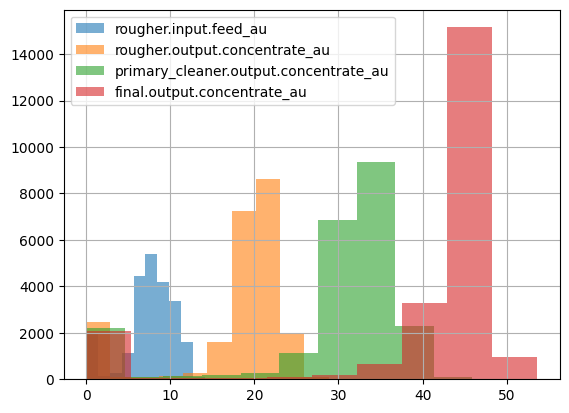

In [29]:
ore_purity('au')

#### Lead

Lead also shows a gradual increase of concentration from start to finish; although the gaps (of refinement) between the stages are a bit smaller or narrower compared to Gold.

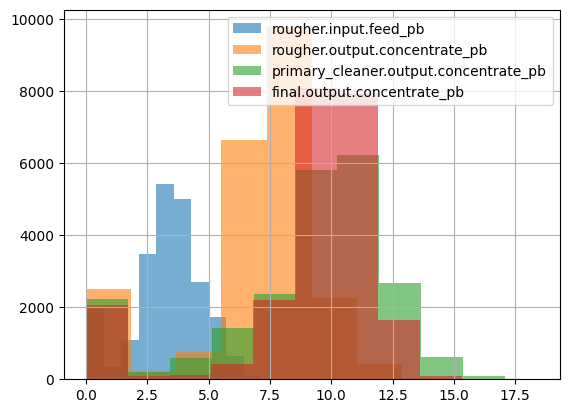

In [30]:
ore_purity('pb')

#### Silver

As for Silver's processing stage, you can see there's an inital general increasing trend of silver concentration until the final stage -- it shows its peak where it does not excel beyond *rougher.output.concentrate* & *primary_cleaner.output.concentrate* and this could be interpreted as the final stage does more harm than good as the cleaning process may dilute or erode the mineral?

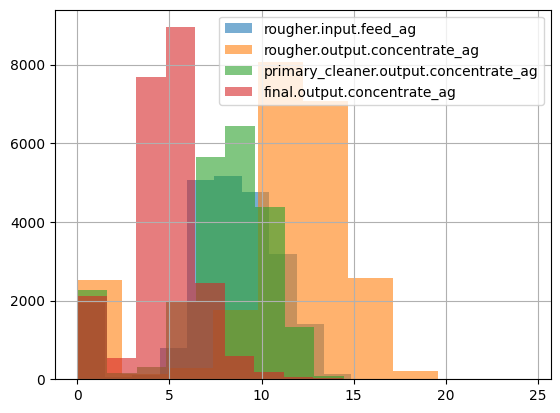

In [31]:
ore_purity('ag')

### Feed Particle Size Comparsion Between the Training & Testing Set

Although both sets have similiar feed size their mean size difference is 2.73 and STD difference is 1.2. Although, I believe the KDE plot shows visual wise that the testing set has a slightly wider feed particle size distribution compared to the training set. 

In [32]:
train['rougher.input.feed_size'].describe()

count    16443.000000
mean        58.676444
std         23.922591
min          9.659576
25%         47.575879
50%         54.104257
75%         65.051064
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [33]:
test['rougher.input.feed_size'].describe()

count    5834.000000
mean       55.937535
std        22.724254
min         0.046369
25%        43.890852
50%        50.002004
75%        61.638434
max       477.445473
Name: rougher.input.feed_size, dtype: float64

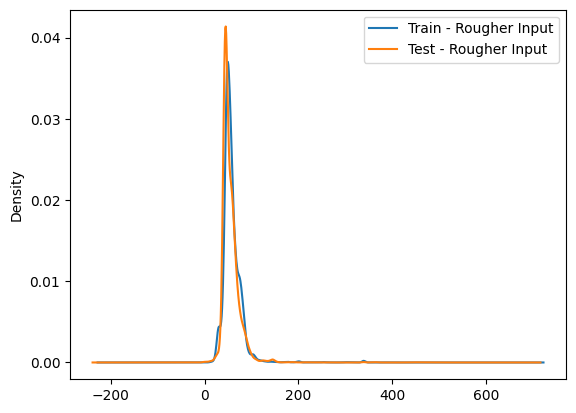

In [34]:
train['rougher.input.feed_size'].plot(kind='kde', label='Train - Rougher Input')
test['rougher.input.feed_size'].plot(kind='kde', label='Test - Rougher Input')
plt.legend(loc='upper right')
plt.show()

### Analysis on the Stages of all substances and their concentrations

Here are all the four substances: Ag - Silver |  Pb - Lead | Sol - Colloid | Au - Gold |

In my opinion, it seems like there isn't any values, at any stage, for any concentrate that sticks out as crazy abnormal for the total distribution --- this to me is further proven visually which each stages' histograms.

In [35]:
ore_stages = full[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol',
                  'rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
                  'final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol']]
ore_stages.head(5)

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol
0,6.486150,6.100378,2.284912,36.808594,19.793808,11.500771,7.101074,28.029297,42.192020,6.055403,9.889648,5.507324
1,6.478583,6.161113,2.266033,35.753385,20.050975,11.615865,7.278807,28.067063,42.701629,6.029369,9.968944,5.257781
2,6.362222,6.116455,2.159622,35.971630,19.737170,11.695753,7.216833,27.454037,42.657501,6.055926,10.213995,5.383759
3,6.118189,6.043309,2.037807,36.862241,19.320810,11.915047,7.175616,27.341277,42.689819,6.047977,9.977019,4.858634
4,5.663707,6.060915,1.786875,34.347666,19.216101,12.411054,7.240205,27.041023,42.774141,6.148599,10.142511,4.939416


#### Raw Feed & Histogram

In [36]:
feed = ore_stages[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol']]
feed.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol
0,6.486150,6.100378,2.284912,36.808594
1,6.478583,6.161113,2.266033,35.753385
2,6.362222,6.116455,2.159622,35.971630
3,6.118189,6.043309,2.037807,36.862241
4,5.663707,6.060915,1.786875,34.347666


<AxesSubplot:>

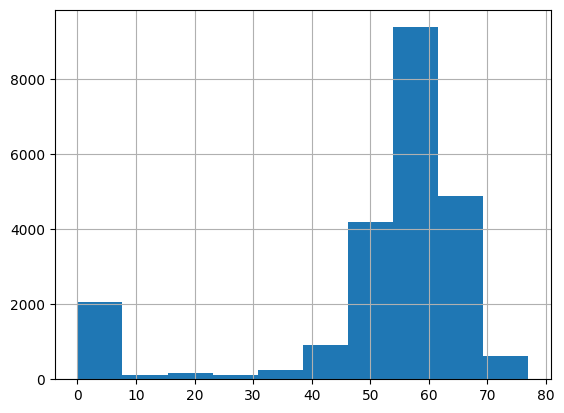

In [37]:
# feed.hist(alpha=0.6, bins=10)
# plt.show()

feed.sum(axis=1).hist()

#### Rougher Concentrate & Histogram

In [38]:
output = ore_stages[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol']]
output.head()

,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol
0,19.793808,11.500771,7.101074,28.029297
1,20.050975,11.615865,7.278807,28.067063
2,19.737170,11.695753,7.216833,27.454037
3,19.320810,11.915047,7.175616,27.341277
4,19.216101,12.411054,7.240205,27.041023


<AxesSubplot:>

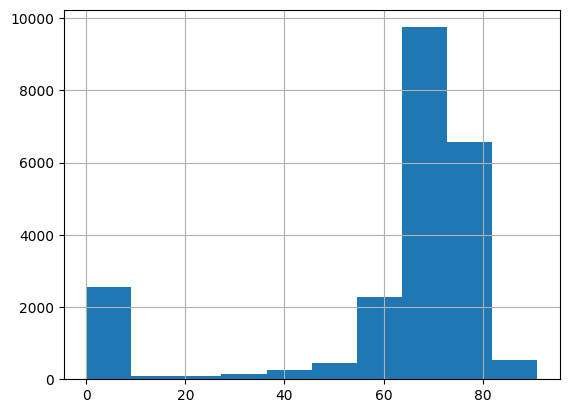

In [39]:
output.sum(axis=1).hist()

#### Final Concentrate & Histogram

In [40]:
final = ore_stages[['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol']]
final.head()

,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol
0,42.192020,6.055403,9.889648,5.507324
1,42.701629,6.029369,9.968944,5.257781
2,42.657501,6.055926,10.213995,5.383759
3,42.689819,6.047977,9.977019,4.858634
4,42.774141,6.148599,10.142511,4.939416


<AxesSubplot:>

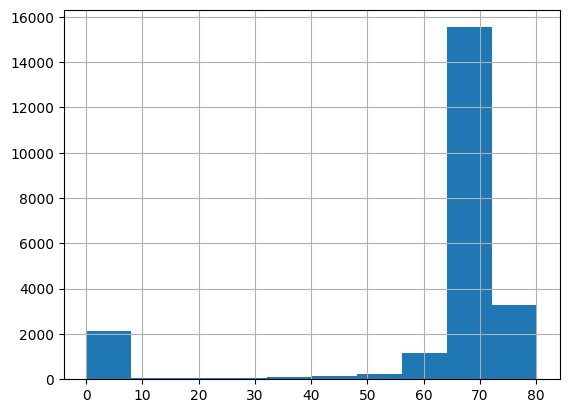

In [41]:
final.sum(axis=1).hist()

## Machine Learning

### sMAPE Function & Formulas

$$
Final \,\ sMAPE = 25\% \,\ x\,\ sMAPE(rougher) + 75\% \,\ x\,\ sMAPE(final)
$$

This is to predict two needed values, as these are our target:
* Rougher Concentrate Recovery (rougher.output.recovery)
* Final Concentrate Recovery (final.output.recovery)

In [42]:
def smape(trgt, pred, epsilon=1e-10):
    return (1 / len(trgt)) * np.sum(np.abs(pred - trgt) / (np.abs(trgt) + np.abs(pred) + epsilon) * 100)

def f_smape(y, pred):
    final = smape(y[:, 0], pred[:, 0])
    rougher = smape(y[:, 1], pred[:, 1])
    return rougher * 0.25 + final * 0.75

custom_scorer = make_scorer(f_smape, greater_is_better=False)

In [43]:
test = test.merge(full[['final.output.recovery', 'rougher.output.recovery']], how='left', left_index=True, right_index=True)

target_columns = ['final.output.recovery', 'rougher.output.recovery']
train = train.dropna(subset=target_columns)
test = test.dropna(subset=target_columns)

train = train.ffill()
test = test.ffill()

train_features = train.drop(['final.output.recovery', 'rougher.output.recovery', 'date'], axis=1)
test_features = test.drop(['final.output.recovery', 'rougher.output.recovery', 'date'], axis=1)
mutual_col = train_features.columns.intersection(test_features.columns).tolist()
train_features = train_features[mutual_col]
test_features = test_features[mutual_col]
train_target = np.array(train[['final.output.recovery', 'rougher.output.recovery']])
test_target = np.array(test[['final.output.recovery', 'rougher.output.recovery']])

In [44]:
print('Train Features Shape:', train_features.shape)
print('Train Target Shape:', train_target.shape)
print('Test Features Shape:', test_features.shape)
print('Test Target Shape:', test_target.shape)

Train Features Shape: (14149, 52)
Train Target Shape: (14149, 2)
Test Features Shape: (4970, 52)
Test Target Shape: (4970, 2)


### Models Training

#### Linear Regression Model

In [45]:
lr_model = LinearRegression()
lr_cvs = cross_val_score(lr_model, train_features, train_target, cv=5, scoring=custom_scorer)
lr_cvs_mean = np.mean(lr_cvs)
print(f"Cross-Valid Score: {-lr_cvs_mean}")

Cross-Valid Score: 6.19229805241832


#### Random Forest Regressor Model

In [46]:
#does the "CV" in the randomizedsearch

rfr_param = {'n_estimators': [10, 15, 25], 'max_depth': [5, 10, 15], 'max_features':[3, 5, 10]}

rfr_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=12345),
    param_distributions=rfr_param,
    scoring=custom_scorer,
    cv=5,
    n_iter=10,
)

rfr_random.fit(train_features, train_target)

best_rfr_model = rfr_random.best_estimator_
best_cv_score = rfr_random.best_score_

print('Best Model Parameters:', best_rfr_model)
print()
print("Best cross-validation score:", -best_cv_score)

Best Model Parameters: RandomForestRegressor(max_depth=5, max_features=10, n_estimators=15,
                      random_state=12345)

Best cross-validation score: 5.074856782132346


#### Decision Tree Regressor Model

In [47]:
dtr_param = {'max_depth': [2, 3, 4, 5, 10, 15], 'splitter': ['best', 'random']}

dtr_random = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(random_state=12345),
    param_distributions=dtr_param,
    scoring=custom_scorer,
    cv=5,
    n_iter=12,
    n_jobs=-1
)

dtr_random.fit(train_features, train_target)

print(f"Best parameters: {dtr_random.best_params_}")
best_cv_score = dtr_random.best_score_
print(f"Best cross-validation score: {-best_cv_score}")

Best parameters: {'splitter': 'best', 'max_depth': 5}
Best cross-validation score: 5.476334421334242


In short, the models training performance ranked up as follows:
* The best model: **RandomForestRegressor** -- 5.07 sMAPE Score
* Second Best: *DecisionTreeRegressor* -- 5.47 sMAPE Score
* Third Best: *LinearRegression* -- 6.19 sMAPE Score

#### Winner Model : Random Forest Regressor

In [48]:
#this is perfect but it needs better distinctive pararameters

test_ft = test.drop(['final.output.recovery', 'rougher.output.recovery', 'date'], axis=1)
test_trgt = np.array(test[['final.output.recovery', 'rougher.output.recovery']])

# Old lines of code
# rfr_model = RandomForestRegressor(n_estimators = 25, max_depth=3, random_state=12345)
# rfr_model.fit(train_features, train_target)

#New line of code with RandomSearchCV
# best_rfr_model.fit(test_ft, test_trgt)


final_rfr_predict = best_rfr_model.predict(test_ft)
final_score = f_smape(test_trgt, final_rfr_predict)
print(f'Final sMAPE score: {final_score}')

Final sMAPE score: 6.127941740854429


#### Dummy Regressor | Baseline Model

In [49]:
#Later the testing set for the final evaul also on the DRegress
dum_reg = DummyRegressor(strategy='mean')
dum_reg.fit(train_features, train_target)
dum_reg_pred = dum_reg.predict(test_ft)
dum_smape = f_smape(test_trgt, dum_reg_pred)

print(f"Dummy Regressor sMAPE: {dum_smape}")

Dummy Regressor sMAPE: 5.613382990479946


Throughout the model development from assessing the datas' missing values, feature engineering columns to matching dataframes' shapes across the board, there was a relative clear performance in how much the data can reveal about itself - and in my opinion and in this case, this taught me how irregular, incomplete data can potentially influence a model's performance. Initially when I developed the final model, I could see a clear progression in its performance: the deeper the depth of the forest, the better it was at detecting the data's patterns. However, when I was training several models during the training phase I had noticed the data was fine-tuning well and strongly favoring the **RandomForestRegressor** and to attempt avoiding overfitting and long computational times, I applied hyperparameters aimed to reduce the two elements' influence. 

My best-performed model at the final testing stage yield a sMAPE score at **6.12**, which is pretty decent compared to its training score of 5.07 (with a -1.05 difference) when it processed the unseen data. I initally didn't have a final Dummy Regressor to compare to but when I developed it, its results yielded a **5.61 sMAPE score**. That is a +0.51 larger error margin leaning more on my model than the comparison, it was clearly outshining my model without any hyperparameters. However, when further exploring attempts at lowering the final model's score, the more I realized looking and comparing all the scores, my final model's performance is actually quite fair given how the data was presented. But I also understand that, if there was further attempt at decreasing the final model's score definitely seeking out other better performing hyperparameters to retrieving more data from the original source will be benefit at improving the final model's results.

# Conclusion

While on this ore-data mining journey, a sigificant level of data judgement is required when analyzing all the data at hand when optimizing the production of ore and eliminating unwanted elements or parameters while attempting at making a ML prototype. I believe the **RandomForestRegressor** Model prototype has proven its accuracy capability (through juggling complex relationships between data and attempting at reducing overfitting and) being as close to calculating the most accurate predictions within the ore-retention recovery process. Although the 2nd and 3rd runner ups' accuracy performed well it didn't do as consistently by seeking out effective patterns in the data, unlike the best-performing model.